Installing libraries for Geographical data interpretation
I am going to use DBSCN Algorithm for clustering as DBSCAN groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions. Therefore this algorithm is better than K-Means Clustering algorithm for clustering geological data.

In [7]:
!pip install --user geopy
!pip install --user shapely
import pandas as pd,numpy as np, matplotlib.pyplot as plt,time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt
import csv
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/rabbitmq/rabbitmq-server/pypi/simple
You are using pip version 18.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://packagecloud.io/rabbitmq/rabbitmq-server/pypi/simple
  Using cached https://files.pythonhosted.org/packages/a2/6c/966fa320a88fc685c956af08135855fa84a1589631256abebf73721c26ed/Shapely-1.6.4.post2-cp35-cp35m-manylinux1_x86_64.whl
You are using pip version 18.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Function to get the centermost point of a cluster.

In [10]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

Converted the POI data points to pandas dataframe.

In [90]:
df=pd.read_csv('data.csv')

df.head()

Implementing DBSCAN Clustering Algorithm and considering only important clusters i.e. clusters with more than 2 POI. 

In [216]:
def dbscan_reduce(df, epsilon, x='longitude', y='latitude'):
    start_time = time.time()
    coords=df.values
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    print('Number of clusters: {:,}'.format(num_clusters))
    count=0
    l=[]
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    k=0
    for i in clusters:
        j=0
        if (len(i)<=2):
            count=count+1
            k=k+1
            l.append(k-1)
            continue
        else:
            k=k+1
    print (num_clusters-count)    
    # find the point in each cluster that is closest to its centroid
    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    rep_points = pd.DataFrame({x:lons, y:lats})
    rep_points.tail()
    
    # pull row from original data set where lat/lon match the lat/lon of each row of representative points
    rs = rep_points.apply(lambda row: df[(df[y]==row[y]) & (df[x]==row[x])].iloc[0], axis=1)
    
    # all done, print outcome
    message = 'Clustered {:,} points down to {:,} points, for {:.2f}% compression in {:,.2f} seconds.'
    print(message.format(len(df), len(rs), 100*(1 - float(len(rs)) / len(df)), time.time()-start_time)) 
    rs=rs.drop(l,axis=0)
    return rs

EPS parameter value is set and the Reduced dataframe is saved to csv file.

In [239]:
kms_per_radian = 6371.0088
eps_rad = 0.05 / kms_per_radian
df_clustered= dbscan_reduce(df, epsilon=eps_rad)
df_clustered.to_csv(r'data_final.csv')

Number of clusters: 1,981
236
Clustered 3,347 points down to 1,981 points, for 40.81% compression in 2.45 seconds.
       latitude  longitude
2     51.576035   0.028058
5     51.517552  -0.119331
6     51.516349  -0.119922
7     51.514735  -0.098382
9     51.511416  -0.077698
11    51.540499  -0.144238
12    51.541352  -0.146282
15    51.511278  -0.131363
16    51.512056  -0.129997
17    51.543258  -0.103413
22    51.470918  -0.082378
25    51.536738  -0.061565
27    51.519093  -0.058937
34    51.492338  -0.192969
42    51.498775  -0.141226
52    51.512345  -0.104467
59    51.497282  -0.312728
62    51.591144  -0.007950
66    51.578662  -0.124049
70    51.514223  -0.187623
71    51.514797  -0.117529
73    51.517969  -0.115180
74    51.505611  -0.021728
75    51.410697  -0.208811
80    51.512600  -0.141233
94    51.511008  -0.139648
97    51.507164  -0.107511
98    51.630689  -0.175342
101   51.539579   0.000102
105   51.554454  -0.005135
...         ...        ...
1519  51.534970   0.0

Plotting the Important Clusters on a Figure: Latitude v/s Longitude

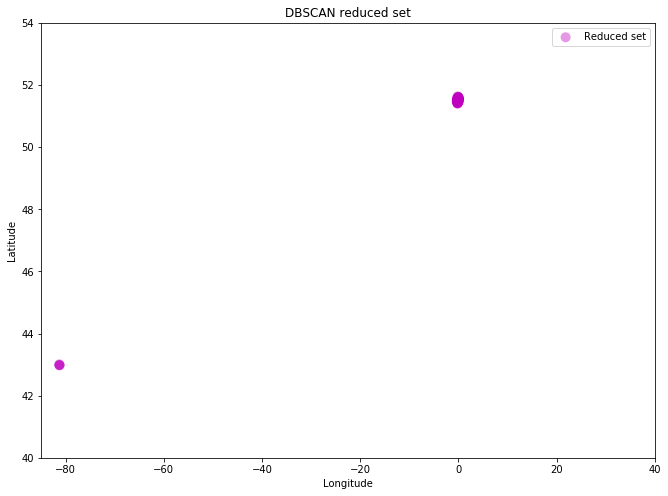

In [238]:
fig, ax = plt.subplots(figsize=[11, 8])
rs_scatter = ax.scatter(df_clustered['longitude'], df_clustered['latitude'], c='m', edgecolor='None', alpha=0.4, s=100)
ax.set_title('DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim([-85, 40])
ax.set_ylim([40, 54])
ax.legend([rs_scatter], ['Reduced set'], loc='upper right')
plt.show()